# Algorytmy tekstowe

## Laboratorium 02

#### Imports

In [1]:
from time import time
from queue import LifoQueue as queue
from random import randint as randint

### Wizualizacja niewielkich drzew
Rzecz przydała się przy debugowaniu i również nie wygląda najgorzej, więc zostawiłem ku uciesze oczu.
Layout drzewa wzięty z platformy [StackOverflow](https://stackoverflow.com/). Reszta wizualizacji jest
autorska.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [20]:
# separator chosen so that the helper part of labels is hidden
separator = "\n" + " " * 440

def flatten_tree(trie):
    q = queue()
    q.put(trie.root)
    nodes = []
    
    while (not q.empty()):
        node = q.get()
        nodes += [node]
        for child in sorted(node.children.values()):
            q.put(child)
            
    return nodes
            
def node_repr(v, i):
    return "\n" + str(v) + separator + str(i)

def visualize(trie, node_repr=node_repr, size=[6.4, 4.8], title=None):
    G = nx.Graph()
    nodes = flatten_tree(trie)
    nrs = {}

    COLOR = [0.0, 0.6, 1.0]
    
    colors = []
    # Add all nodes
    for i, v in enumerate(nodes):
        G.add_node(node_repr(v, i))
        curr_color = COLOR.copy()
        curr_color[0] += 0.2 * v.depth
        if (curr_color[0] > 1.0): curr_color[0] = 1.0
        colors += [curr_color]
        nrs[v] = i
    
    # Add all edges
    for i, v in enumerate(nodes):
        for child in sorted(v.children.values()):
            G.add_edge(node_repr(v, i), node_repr(child, nrs[child]))

    plt.figure(3, figsize=size)
    plt.title(title)
    pos = hierarchy_pos(G, node_repr(trie.root, 0))
    nx.draw(G, pos=pos, with_labels=True, node_color=colors)
    plt.show()

## Zadanie 1

Celem zadania jest zapoznanie się z konstrukcjami trie oraz drzewem sufiksów.

1. Przyjmij następujący zbiór danych wejściowych:
 * bbb\$
 * aabbabd
 * ababcd
 * abcbccd
 * załączony plik.

In [5]:
data1 = "bbb$"
data2 = "aabbabd"
data3 = "ababcd"
data4 = "abcbccd"

file = open("1997_714.txt", "r")
data_file = file.read()
file.close()

## Zadanie 2

2. Upewnij się, że każdy łańcuch na końcu posiada unikalny znak (marker), a jeśli go nie ma, to dodaj ten znak.

In [6]:
print("Are the data sets terminated by a different character:")
print((data1[-1] in data1[:-1]) is False)
print((data2[-1] in data2[:-1]) is False)
print((data3[-1] in data3[:-1]) is False)
print((data4[-1] in data4[:-1]) is False)
print((data_file[-1] in data_file[:-1]) is False)

Are the data sets terminated by a different character:
True
True
True
True
False


In [7]:
# I build data structures only for string not exceeding max_length
max_length = 5000
data5 = data_file[:max_length] + "^"

In [8]:
print("Are the data sets now terminated by a different character:")
print((data1[-1] in data1[:-1]) == False)
print((data2[-1] in data2[:-1]) == False)
print((data3[-1] in data3[:-1]) == False)
print((data4[-1] in data4[:-1]) == False)
print((data5[-1] in data5[:-1]) == False)

Are the data sets now terminated by a different character:
True
True
True
True
True


## Zadanie 3

3. Zaimplementuj algorytm konstruujący strukturę trie, która przechowuje wszystkie sufiksy łańcucha danego na wejściu.

In [9]:
class TrieNode:
    """ Structure representing a trie tree node.
    
    Attributes:
        letter : A letter, which is represented by a node.
        children : List of childrens of a node.
        depth : A depth of the node in a tree.
        parent : A reference to a parent of a node.
    """
    
    def __init__(self, letter="", depth=0, parent=None):
        self.letter = letter
        self.children = {}
        self.depth = depth
        self.parent = parent
        
    def __str__(self):
        return str(self.letter)
    
    def graft(self, suffix, sibling=None):
        prev_node = self
        
        if (suffix):
            for char in suffix:
                node = TrieNode(char, prev_node.depth + 1, prev_node)
                prev_node.children[char] = node
                node.parent = prev_node
                prev_node = node

        return prev_node
    
    def print_subtree(self):
        for child in sorted(self.children.values()):
            print(">", end = " ")
            for _ in range(self.depth):
                print("  ", end = " ")
            print(child)
            child.print_subtree()
    
    def __lt__(self, other):
        return str(self)[0] < str(other)[0]

In [10]:
class Trie:
    def __init__(self, text):
        self.leafs = []
        self.root  = TrieNode()
        self.text = text
        
    def _is_correct(self):          
        if (self.text[-1] in self.text[: -1]):
            raise ValueError("Last character is not unique")
    
    def find(self, suffix, node=None):
        if (suffix == ""): raise ValueError("Trie find called with an empty string")
        if (node == None): node = self.root

        while (True):
            if (not suffix or not node.children):
                return node
            child = node.children.get(suffix[0], None)
            if (child is None or suffix[0] == self.text[-1]):
                return node
            else:
                node = child
                suffix = suffix[1:]

    @classmethod
    def compute_initial(cls, text):
        trie = Trie(text)
        trie.leafs = [trie.root.graft(text)]
        
        return trie
    
    @classmethod
    def build_tree(cls, text):
        trie = Trie.compute_initial(text)
        trie._is_correct()
        leaf = trie.leafs[0]
        
        for i in range(1, len(text)):
            suffix = text[i:]
            head = trie.find(suffix)
            suffix_end = suffix[head.depth:]
            leaf = head.graft(suffix_end)
            
        return trie

    def print_tree(self):
        print("Trie:")
        self.root.print_subtree()
        
    def __contains__(self, suffix):
        if (suffix is ""): return True
        return self.find(suffix).depth == len(suffix)

### Simple Test

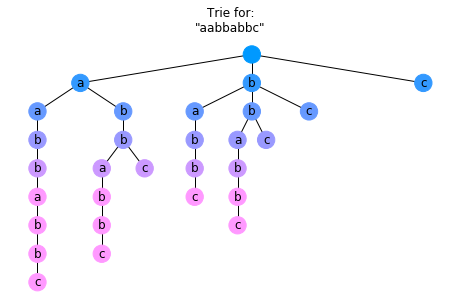

In [21]:
simple_text = "aabbabbc"
trie = Trie.build_tree(simple_text)
visualize(trie, size=[8, 4.8], title="Trie for:\n\"aabbabbc\"")

## Zadanie 4

4. Zaimplementuj algorytm konstruujący drzewo sufiksów w oparciu o algorytm McCreighta.

# Mc Creight

In [12]:
class SuffixNode:
        def __init__(self, tree, letter=None, suffix_begin=-1, pref_len=-1, parent=None, children=None):
            self.letter = '' if not letter else letter
            self._parent = parent  # parent is private due to dynamic calculation of depth 
            self.begin = suffix_begin
            self.len = pref_len  # length of path from the root to the before edge 
            self.children = {} if not children else children
            self.suffix_link = None
            self.tree = tree
            self.depth = 0 if parent is None else parent.depth + 1
        
        @property
        def parent(self):
            return self._parent
        
        @parent.setter
        def parent(self, parent):
            self._parent = parent
            self.depth = parent.depth + 1
        
        def __len__(self):
            return self.len
        
        def add(self, child):
            self.children[child.letter] = child
        
        def __str__(self):
            begin = self.begin + self.parent.len
            end = self.len - self.parent.len + begin
            return self.tree.text[begin : end]
        
        def __lt__(self, other):
            return str(self)[0] < str(other)[0]

In [13]:
class SuffixTree:
    def __init__(self, text=None):
        self.root = SuffixNode(self, suffix_begin=0, pref_len=0)
        self.root.suffix_link = self.root
        self.root.parent = self.root
        self.text = text
    
    @classmethod
    def build_mccreight(cls, text):
        suff_tree = SuffixTree(text)
        suff_tree._is_correct()
        head = suff_tree.root
        text_len = len(text)
        pref_len = 0
        
        for i in range(text_len):
            if (pref_len == len(head) and text[i + pref_len] in head.children):
                head, pref_len = suff_tree._slow_find(i, head, pref_len)
            
            if (len(head) > pref_len):
                head = suff_tree._break_path(head, pref_len)
            suff_tree._create_leaf(i, head, pref_len)
            
            if (head.suffix_link is None):
                suff_tree._fast_find(head, pref_len)
            head = head.suffix_link
            pref_len = len(head)
        
        return suff_tree
    
    @classmethod
    def build_mccreight_slow(cls, text):
        suff_tree = SuffixTree(text)
        suff_tree._is_correct()
        
        head = suff_tree.root
        text_len = len(text)
        pref_len = 0
        
        for i in range(text_len):
            if (pref_len == len(head) and text[i + pref_len] in head.children):
                head, pref_len = suff_tree._slow_find(i, head, pref_len)
            
            if (len(head) > pref_len):
                head = suff_tree._break_path(head, pref_len)
            suff_tree._create_leaf(i, head, pref_len)
            
            pref_len = 0
            head = suff_tree.root
            pref_len = 0
    
        return suff_tree
    
    def _is_correct(self):
        if (self.text is None or self.text is ""):
            raise ValueError("Text is not speccified")
        if (self.text[-1] in self.text[: -1]):
            raise ValueError("Last character is not unique")
    
    def _slow_find(self, cur_begin, head, pref_len):
        while pref_len == len(head) and self.text[cur_begin + pref_len] in head.children:
            head = head.children[self.text[cur_begin + pref_len]]
            pref_len += 1
            while pref_len < len(head) and self.text[cur_begin + pref_len] == self.text[head.begin + pref_len]:
                pref_len += 1
        return head, pref_len
    
    def _break_path(self, node, pref_len):
        parent = node.parent
        new_node = SuffixNode(self, suffix_begin=node.begin, pref_len=pref_len, 
                              letter=self.text[node.begin + len(parent)], parent=parent)
        parent.add(new_node)
        node.parent = new_node
        node.letter = self.text[node.begin + pref_len]
        new_node.add(node)
        
        return new_node
    
    def _create_leaf(self, suffix_begin, head, pref_len):
        leaf = SuffixNode(self, suffix_begin=suffix_begin, pref_len=len(self.text) - suffix_begin,
                          letter=self.text[suffix_begin + pref_len], parent=head)
        head.add(leaf)
        return leaf
    
    def _fast_find(self, head, pref_len):
        next_head = head.parent.suffix_link
        
        while len(next_head) < pref_len - 1:
            next_head = next_head.children[self.text[head.begin + len(next_head) + 1]]
        if len(next_head) > pref_len - 1:
            next_head = self._break_path(next_head, pref_len - 1)
        head.suffix_link = next_head
    
    def __contains__(self, suffix):
        if (suffix is ""): return True
        node = self.root
        
        for depth, letter in enumerate(suffix):
            if (depth == len(node)):
                if (letter not in node.children):
                    return False
                node = node.children[letter]
            elif (letter != self.text[node.begin + depth]):
                return False
        return True

### Simple Test

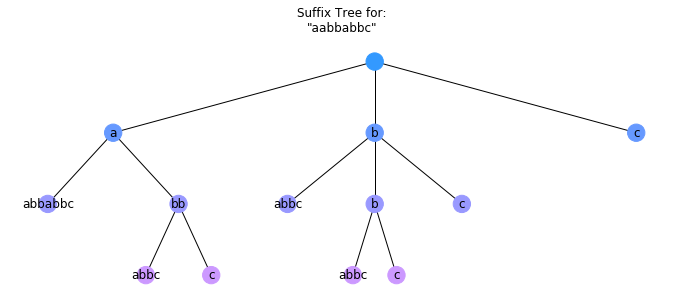

In [14]:
simple_text
suff_tree = SuffixTree.build_mccreight(simple_text)
visualize(suff_tree, size=[12, 4.8], title="Suffix Tree for:\n\"aabbabbc\"")

# Zadanie 5

5. Upewnij się, że powstałe struktury danych są poprawne. Możesz np. sprawdzić, czy struktura zawiera jakiś ciąg znaków i porównać wyniki z algorytmem wyszukiwania wzorców.

In [15]:
def naive(text, pattern): # O((n - m  + 1)m)
    n = len(text)
    m = len(pattern)
    for s in range(n - m + 1):  # O(n - m + 1)
        if (text[s : m + s] == pattern):  # O(m)
            return True

    return False

In [16]:
def test_factorin(text, patterns):
    trie_tree = Trie.build_tree(text)
    suff_tree_fast = SuffixTree.build_mccreight(text)
    suff_tree_slow = SuffixTree.build_mccreight_slow(text)
    print("Trie Tree,   Naive Pattern Matching,   Suffix Tree Fast,   Suffix Tree Slow")
    for pat in patterns:
        print(f"  {pat in trie_tree}, \t    {naive(text, pat)},\
            \t     {pat in suff_tree_fast},\t\t {pat in suff_tree_slow}", end="  ")
        print(f" \t\t{pat}")
    print()

In [17]:
test_example_1 =    "Ciężko jest za dwieście rubli rocznie całe życie kołatać   \
                    jako guwernantka od dworu do dworu, ale ja i tak wiem, że   \
                    moja siostra raczej służyłaby jak Murzynka u plantatora,    \
                    jak Łotyszka u bałtyckiego Niemca, niżby upodliła swą duszę \
                    i poczucie moralne związkiem z człowiekiem, którego nie     \
                    szanuje i z którym nic nie ma wspólnego (…) Więc czemuż     \
                    teraz się zgadza? (…) Sprawa prosta jak drut: nie sprzedała \
                    by siebie dla własnej wygody, nawet dla ocalenia siebie od  \
                    śmierci, lecz dla kogo innego - gotowa się sprzedać! (…) w  \
                    razie konieczności gotowiśmy wziąć w łyka nasze poczucie    \
                    moralne; naszą wolność, spokój, nawet sumienie – wszystko,  \
                    wszystko poniesiemy na targ. Niechaj przepada życie! (…)    \
                    Nie dość tego: wynajdziemy własną kazuistykę, sięgniemy po  \
                    naukę do jezuitów na pewien czas, kto wie, uspokoimy sami   \
                    siebie, wmówimy sobie, że właśnie tak być powinno, bo cel   \
                    jest dobry"
test_example_1 +=   "$"

patterns1 = ["(...)", "(…)", "Raskolnikow", "dla ocal"]



test_example_2 =    "Celem zadania jest zapoznanie się z konstrukcjami trie oraz drzewem sufiksów. \
                    Przyjmij następujący zbiór danych wejściowych: \
                        bbb$ \
                        aabbabd \
                        ababcd \
                        abcbccd \
                        załączony plik. \
                    Upewnij się, że każdy łańcuch na końcu posiada unikalny znak (marker), a jeśli go nie ma, to dodaj ten znak. \
                    Zaimplementuj algorytm konstruujący strukturę trie, która przechowuje wszystkie sufiksy łańcucha danego na wejściu. \
                    Zaimplementuj algorytm konstruujący drzewo sufiksów w oparciu o algorytm McCreighta. \
                    Upewnij się, że powstałe struktury danych są poprawne. Możesz np. sprawdzić, czy struktura zawiera jakiś ciąg znaków i porównać wyniki z algorytmem wyszukiwania wzorców. \
                    Porównaj szybkość działania algorytmów konstruujących struktury danych dla danych z p. 1 w następujących wariantach: \
                        Trie (1 pkt) \
                        Drzewo sufiksów bez wykorzystania procedury fast_find oraz elementów \"link\" (1 pkt) \
                        Drzewo sufiksów z wykorzystaniem procedury fast_find (3 pkty) \
                    Oczekiwany wynik ćwiczenia to kod źródłowy, przykładowe dane, na których testowano algorytmy oraz raport czasów wykonania z punktu 6. \
                    Termin realizacji - 2 tygodnie (6 kwietnia, godz. 12)."

test_example_2 += "#"

patterns2 = ["McCregiht brzmi jak nazwa rapera", "Grecy", "5 kwietnia", "Trie (1 pkt)"]



alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
test_example_3 = ""
for _ in range(100):
    test_example_3 += str(alphabet[randint(0, len(alphabet) - 1)])
test_example_3 += "KAPPA%"

print("\t\t\t\t\t\tRandom text:")
print(test_example_3)
patterns3 = [test_example_3[21 : 37], "stawiamObiad"]

						Random text:
cSEjRQXJIfnpbdoESNWjkQKVGQfUbWADVusNvYYcgLgKtrGWzKcZTpIpQvSXRbnOGwCggYLwOawDeEBSTHkPKVNIfXqofsvPvxtvKAPPA%


In [18]:
test_factorin(test_example_1, patterns1)

Trie Tree,   Naive Pattern Matching,   Suffix Tree Fast,   Suffix Tree Slow
  False, 	    False,            	     False,		 False   		(...)
  True, 	    True,            	     True,		 True   		(…)
  False, 	    False,            	     False,		 False   		Raskolnikow
  True, 	    True,            	     True,		 True   		dla ocal



In [19]:
test_factorin(test_example_2, patterns2)

Trie Tree,   Naive Pattern Matching,   Suffix Tree Fast,   Suffix Tree Slow
  False, 	    False,            	     False,		 False   		McCregiht brzmi jak nazwa rapera
  False, 	    False,            	     False,		 False   		Grecy
  False, 	    False,            	     False,		 False   		5 kwietnia
  True, 	    True,            	     True,		 True   		Trie (1 pkt)



In [20]:
test_factorin(test_example_3, patterns3)

Trie Tree,   Naive Pattern Matching,   Suffix Tree Fast,   Suffix Tree Slow
  True, 	    True,            	     True,		 True   		QKVGQfUbWADVusNv
  False, 	    False,            	     False,		 False   		stawiamObiad



# Zadanie 6

6. Porównaj szybkość działania algorytmów konstruujących struktury danych dla danych z p. 1 w następujących wariantach:
    
 * Trie (1 pkt)
 * Drzewo sufiksów bez wykorzystania procedury fast_find oraz elementów "link" (1 pkt)
 * Drzewo sufiksów z wykorzystaniem procedury fast_find (3 pkty)

In [21]:
def timeit(method):
    """ Decorator for measuring time.
    It shows arguments of function.
    """
    
    def timed(*args, **kw):
        num_of_meas = 5
        time_measurement = 0.0
        for _ in range(num_of_meas):
            ts = time()
            result = None
            result = method(*args, **kw)
            te = time()
            time_measurement += (te - ts) * 1000 / num_of_meas
        
        MAGIC_NUM = 20
        def truncate(arg):
            arg = " ".join(arg.split())
            if (isinstance(arg, str) and len(arg) > MAGIC_NUM):
                return arg[: MAGIC_NUM] + "..."
            else:
                return arg
        args = list(map(truncate, args))
        if (len(args) == 1):
            args = args[0]
            
        print("%s%23s \t %10.3f ms" % (method.__name__, ("(" + str(args) + ")").ljust(23), time_measurement))
        return result
    return timed

In [22]:
@timeit
def trie_build_time_meas(text):
    return Trie.build_tree(text)

@timeit
def suff_build_time_meas(text):
    return SuffixTree.build_mccreight(text)

@timeit
def suff_build_slow_time_meas(text):
    return SuffixTree.build_mccreight_slow(text)

## Trie Tests

In [39]:
# Measurements of Trie building
trie_data1 = trie_build_time_meas(data1)
trie_data2 = trie_build_time_meas(data2)
trie_data3 = trie_build_time_meas(data3)
trie_data4 = trie_build_time_meas(data4)

trie_build_time_meas(bbb$)                  	      0.020 ms
trie_build_time_meas(aabbabd)               	      0.055 ms
trie_build_time_meas(ababcd)                	      0.071 ms
trie_build_time_meas(abcbccd)               	      0.057 ms


### Test Trie Killer

In [40]:
# Cleanup (RAM saving - believing in garbage collector)
trie_data5 = None
suff_data5_sl = None
suff_data5 = None

# Measurement of Trie building on string having max_length=7500 characters
# It  RAM
# Be careful - comment out the statement you think is not true.
Yes = True
No = False
I_JUST_WANT_TO_DIE = Yes
I_JUST_WANT_TO_DIE = No
if (I_JUST_WANT_TO_DIE):
    trie_data5 = trie_build_time_meas(data5)

trie_build_time_meas(Dz.U. z 1998 r. Nr 1...) 	 100888.384 ms


<b>
Kopia wyniku:
<br>
trie_build_time_meas(Dz.U. z 1998 r. Nr 1...) 	 100888.384 ms
</b>

### Wizualizacja powstałych pomniejszych struktur

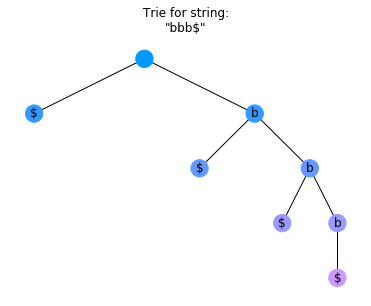

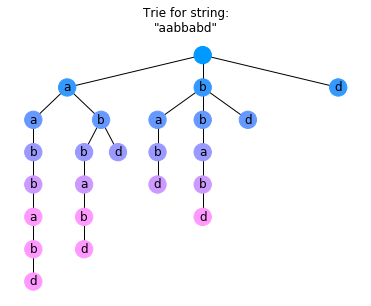

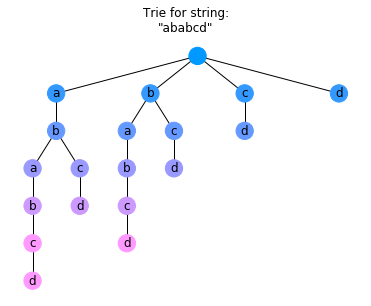

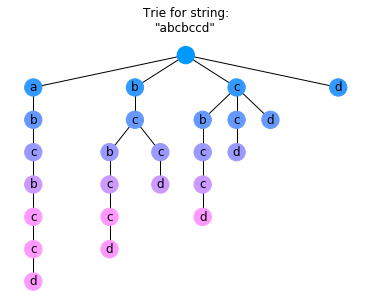

In [41]:
visualize(trie_data1, title="Trie for string:\n\"bbb$\"")
visualize(trie_data2, title="Trie for string:\n\"aabbabd\"")
visualize(trie_data3, title="Trie for string:\n\"ababcd\"")
visualize(trie_data4, title="Trie for string:\n\"abcbccd\"")

## McCreight Tests

In [42]:
# Cleanup (RAM saving - believing in garbage collector)
trie_data5 = None
suff_data5_sl = None
suff_data5 = None

# Measurements of slow McCreight
suff_data1_sl = suff_build_slow_time_meas(data1)
suff_data2_sl = suff_build_slow_time_meas(data2)
suff_data3_sl = suff_build_slow_time_meas(data3)
suff_data4_sl = suff_build_slow_time_meas(data4)
suff_data5_sl = suff_build_slow_time_meas(data5)
# Measurements of fast McCreight
suff_data1 = suff_build_time_meas(data1)
suff_data2 = suff_build_time_meas(data2)
suff_data3 = suff_build_time_meas(data3)
suff_data4 = suff_build_time_meas(data4)
suff_data5 = suff_build_time_meas(data5)

suff_build_slow_time_meas(bbb$)                  	      0.031 ms
suff_build_slow_time_meas(aabbabd)               	      0.042 ms
suff_build_slow_time_meas(ababcd)                	      0.030 ms
suff_build_slow_time_meas(abcbccd)               	      0.040 ms
suff_build_slow_time_meas(Dz.U. z 1998 r. Nr 1...) 	    125.579 ms
suff_build_time_meas(bbb$)                  	      0.046 ms
suff_build_time_meas(aabbabd)               	      0.189 ms
suff_build_time_meas(ababcd)                	      0.058 ms
suff_build_time_meas(abcbccd)               	      0.090 ms
suff_build_time_meas(Dz.U. z 1998 r. Nr 1...) 	     73.619 ms


### Wizualizacja powstałych pomniejszych struktur

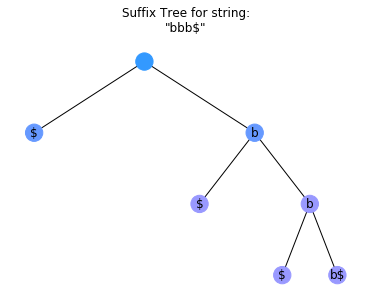

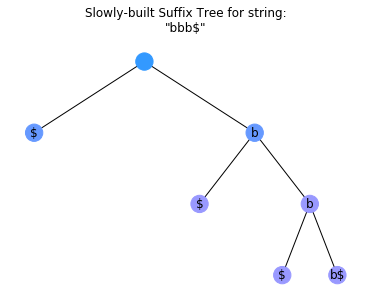

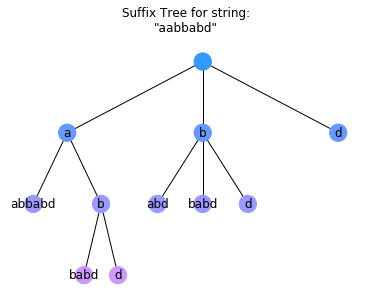

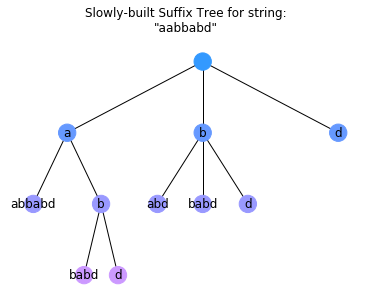

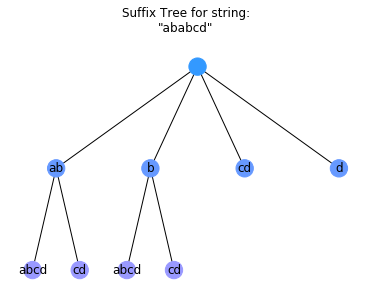

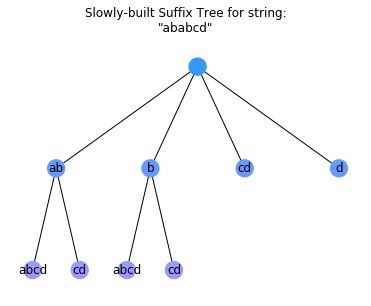

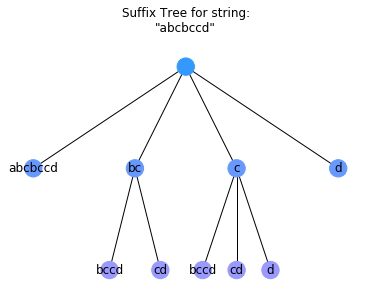

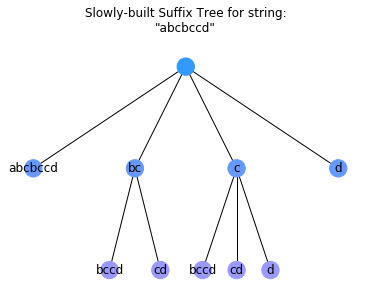

In [43]:
visualize(suff_data1, title="Suffix Tree for string:\n\"bbb$\"")
visualize(suff_data1_sl, title="Slowly-built Suffix Tree for string:\n\"bbb$\"")
visualize(suff_data2, title="Suffix Tree for string:\n\"aabbabd\"")
visualize(suff_data2_sl, title="Slowly-built Suffix Tree for string:\n\"aabbabd\"")
visualize(suff_data3, title="Suffix Tree for string:\n\"ababcd\"")
visualize(suff_data3_sl, title="Slowly-built Suffix Tree for string:\n\"ababcd\"")
visualize(suff_data4, title="Suffix Tree for string:\n\"abcbccd\"")
visualize(suff_data4_sl, title="Slowly-built Suffix Tree for string:\n\"abcbccd\"")